# Convolutional Variational Autoencoder

**Dataset**: MNIST Dataset from Keras API

**Reference**: [Convolutional Variational Autoencoder](https://www.tensorflow.org/tutorials/generative/cvae)

A VAE is a `probabilistic` take on the autoencoder, a model which takes high dimensional input data and compresses it into a smaller representation. Unlike a traditional autoencoder, which maps the input onto a latent vector, a VAE maps the input data into the parameters of a `probability distribution`, such as the `mean` and `variance` of a `Gaussian`. This approach produces a continuous, structured latent space, which is useful for image generation.



![](https://learnopencv.com/wp-content/uploads/2020/11/vae-diagram-1-1024x563.jpg)

In [1]:
# import the necessary packages
import imageio
import glob
import os
import time
import cv2
import tensorflow as tf
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

%matplotlib inline

### VAE Implementation

* Create Model including Encoder and Decoder models
* Use Reparameterization trick for mapping
* KL divergence loss
* Reconstruction loss
* Sampling

### Load and Preprocess Data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
def preprocess_images(images, scale=False):
  images = images.reshape((images.shape[0], 28, 28, 1)).astype('float32')
  if scale:
    images /= 255.
  return images

In [5]:
train_images = preprocess_images(x_train)
test_images = (x_test.astype('float32')) / 255.

In [6]:
TRAIN_SIZE = 60000
TEST_SIZE = 10000

BATCH_SIZE = 128

In [7]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_SIZE).batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_SIZE).batch(BATCH_SIZE))  # Optional, not required

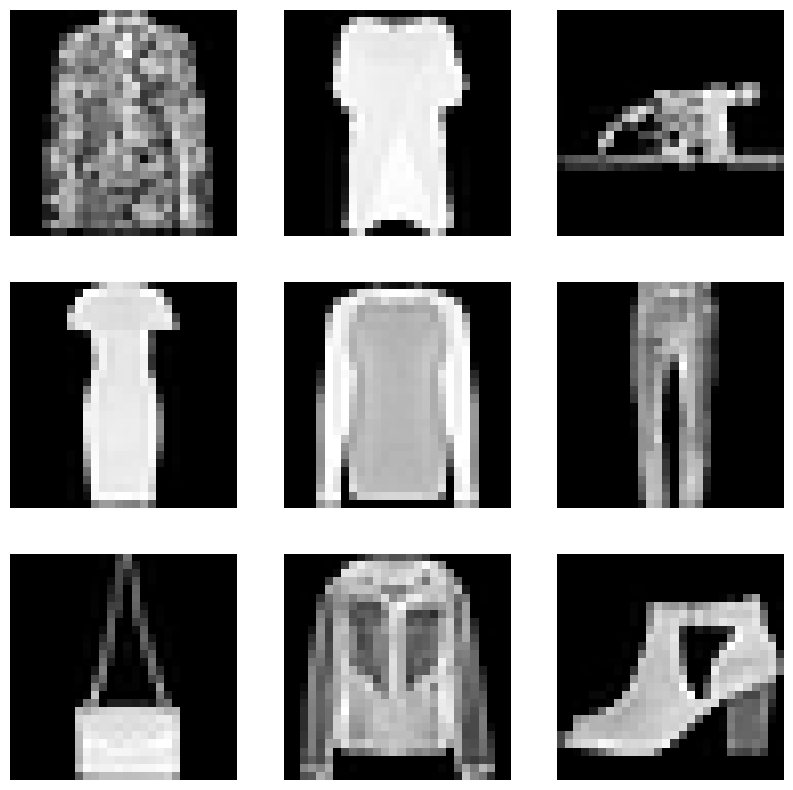

In [8]:
plt.figure(figsize=(10, 10))
for images in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i,:,:,0].numpy().astype("uint8"), cmap='gray')
        plt.axis("off")

### Normalization Layer (Rescaling)

In [9]:
from tensorflow.keras import layers, Model

In [10]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./255)
normalized_train_dataset = train_dataset.map(lambda x: normalization_layer(x))

In [15]:
image_batch = next(iter(normalized_train_dataset))
first_image = image_batch[0]

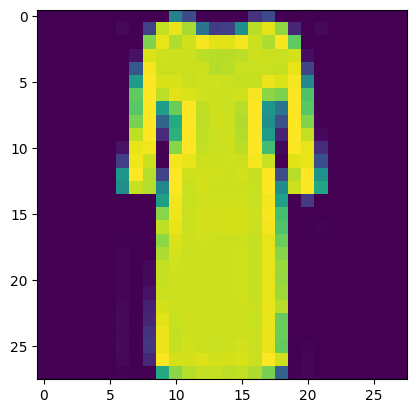

In [16]:
plt.imshow(first_image)

### Encoder Network

This defines the approximate posterior distribution `q(z|x)`, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation `z`. In this example, simply model the distribution as a `diagonal Gaussian`, and the network outputs the `mean` and `log-variance` parameters of a factorized Gaussian. Output `log-variance` instead of the variance directly for numerical stability.

In [17]:
def create_encoder_model(input_encoder, latent_dim):
    inputs = keras.Input(shape=input_encoder, name='input_layer')

    # Block-1
    x = layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)

    # Block-2
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)

    # Block-3
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)

    # Block-4
    x = layers.Conv2D(64, 3, 1, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)

    # Final Block
    flatten = layers.Flatten()(x)  # (None, 7, 7, 64) to (None, 3136)

    # Latent variables
    mean = layers.Dense(latent_dim, name='mean')(flatten)
    log_var = layers.Dense(latent_dim, name='log_var')(flatten)
    # Model
    model = Model(inputs, (mean, log_var), name="Encoder")

    model.summary()
    keras.utils.plot_model(model, "encoder_model.png")
    return model

### Decoder network

This defines the conditional distribution of the observation p(x|z), which takes a latent sample as input and outputs the parameters for a conditional distribution of the observation. Model the latent distribution prior p(z) as a unit Gaussian.

In [18]:
def create_decoder_model(input_decoder):
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(3136, name='dense_1')(inputs)
    x = layers.Reshape((7, 7, 64), name='Reshape_Layer')(x)

    # Block-1
    x = layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)

    # Block-2
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)

    # Block-3
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)

    # Block-4
    outputs = layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")

    model.summary()
    keras.utils.plot_model(model, "decoder_model.png")
    return model

### The Sampling Network

In [19]:
def sampling(input_mean, input_logvar):
    mean = keras.Input(shape=input_mean, name='input_mean')
    log_var = keras.Input(shape=input_logvar, name='input_logvar')

    out = layers.Lambda(sampling_reparameterization_model, name='encoder_output')([mean, log_var])
    enc_2 = keras.Model([mean, log_var], out,  name="Encoder_2")

    enc_2.summary()
    keras.utils.plot_model(enc_2, "sampling_model.png")
    return enc_2

### Reparameterization trick

To generate a sample `z` for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation `x`. However, this sampling operation creates a bottleneck because `backpropagation cannot flow through a random node`. To address this issue, we use a `reparameterization trick`.

![](https://learnopencv.com/wp-content/uploads/2020/11/reparam-vae-1024x479.jpg)

![](https://mlarchive.com/wp-content/uploads/2022/10/Screen-Shot-2022-10-08-at-1.59.49-PM-1-768x225.png)

Generate epsilon from standard normal distribution. The latent variable z is now generated by a function of mean, variance and epsilon, which would enable the model to backpropagate gradients in the encoder through mean and variance respectively, while maintaining stochasticity through epsilon.

In [20]:
from keras import backend as K

def sampling_reparameterization_model(distribution_params):
    mean, log_var = distribution_params
    epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
    z = mean + K.exp(log_var / 2) * epsilon   # z = μ + ε*log(σ)*0.5
    return z

### Loss Functions and Optimizer

![](https://miro.medium.com/v2/resize:fit:720/0*jhi0jGQl9rZoqOvI)

### Optimizer

In [21]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
optimizer = tf.keras.optimizers.legacy.Adam(lr = 0.0005)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
def mse_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return 1000 * r_loss

In [23]:
def kl_loss(mean, log_var):
    kl_loss_result =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    return kl_loss_result

In [24]:
def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred)
    kl_loss_result = kl_loss(mean, log_var)
    return  r_loss + kl_loss_result

### Training the Model

* Start by iterating over the dataset
* During each iteration, pass the image to the encoder to obtain a set of `mean` and `log-variance` parameters of the approximate posterior `q(z|x)` then apply the reparameterization trick to sample from `q(z|x)`
* Pass the `reparameterized samples` to the decoder to obtain the logits of the generative distribution `p(x|z)`

In [25]:
EPOCHS = 50
INPUT_SHAPE = (28, 28, 1)

# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2

num_examples_to_generate = 16

### Get Encoder and Decoder Models

In [26]:
encoder_model = create_encoder_model(INPUT_SHAPE, latent_dim)
decoder_model = create_decoder_model(latent_dim)

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 28, 28, 32)           320       ['input_layer[0][0]']         
                                                                                                  
 bn_1 (BatchNormalization)   (None, 28, 28, 32)           128       ['conv_1[0][0]']              
                                                                                                  
 lrelu_1 (LeakyReLU)         (None, 28, 28, 32)           0         ['bn_1[0][0]']                
                                                                                            

In [27]:
input_mean = (2,)
input_logvar = (2,)

In [28]:
sampling_model = sampling(input_mean, input_logvar)

Model: "Encoder_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_mean (InputLayer)     [(None, 2)]                  0         []                            
                                                                                                  
 input_logvar (InputLayer)   [(None, 2)]                  0         []                            
                                                                                                  
 encoder_output (Lambda)     (None, 2)                    0         ['input_mean[0][0]',          
                                                                     'input_logvar[0][0]']        
                                                                                                  
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 

In [29]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
        mean, log_var = encoder_model(images, training=True)
        latent = sampling_model([mean, log_var])   # Reparametrization
        generated_images = decoder_model(latent, training=True)
        loss = vae_loss(images, generated_images, mean, log_var)

    gradients_of_enc = encoder.gradient(loss, encoder_model.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, decoder_model.trainable_variables)

    optimizer.apply_gradients(zip(gradients_of_enc, encoder_model.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, decoder_model.trainable_variables))

In [30]:
TRAINING_WEIGHT_DIR = "tf_vae/fashion/training_weights"
IMGS_DIR = "tf_vae/fashion/images"

In [34]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)

        seed = image_batch[:25]
        display.clear_output(wait=True)
        generate_and_save_images([encoder_model, sampling_model, decoder_model],
                                  epoch + 1,
                                  seed)

        # Save the model every 5 epochs
        if (epoch + 1) % 5 == 0:
          encoder_model.save_weights(TRAINING_WEIGHT_DIR + '/encoder_model_'+ str(epoch)+'.h5')
          decoder_model.save_weights(TRAINING_WEIGHT_DIR + '/decoder_model_'+ str(epoch)+'.h5')

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images([encoder_model, sampling_model, decoder_model],
                            epochs,
                            seed)

In [32]:
os.makedirs(TRAINING_WEIGHT_DIR, exist_ok=True)
os.makedirs(IMGS_DIR, exist_ok=True)

### Generating Images

In [35]:
def generate_and_save_images(model, epoch, test_input):
  # All layers run in inference mode (batchnorm).
  mean, var = encoder_model(test_input, training=False)
  latent = sampling_model([mean,  var])
  predictions = decoder_model(latent, training=False)

  print(predictions.shape)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(5, 5, i+1)
    plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray')
    plt.axis('off')

  plt.savefig(IMGS_DIR + '/image_at_epoch_{:d}.png'.format(epoch))
  plt.show()

(25, 28, 28, 1)


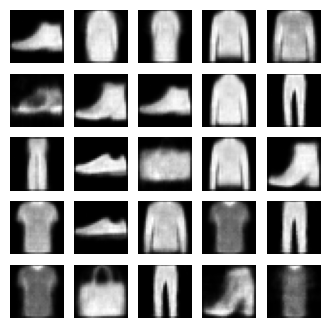

In [36]:
train(normalized_train_dataset, EPOCHS)

### Load weights

In [37]:
encoder_model.load_weights(TRAINING_WEIGHT_DIR + '/encoder_model_49.h5')
decoder_model.load_weights(TRAINING_WEIGHT_DIR + '/decoder_model_49.h5')

### Latent Space Projection of VAE trained on Fashion-MNIST

157/157 [==============================] - 0s 2ms/step


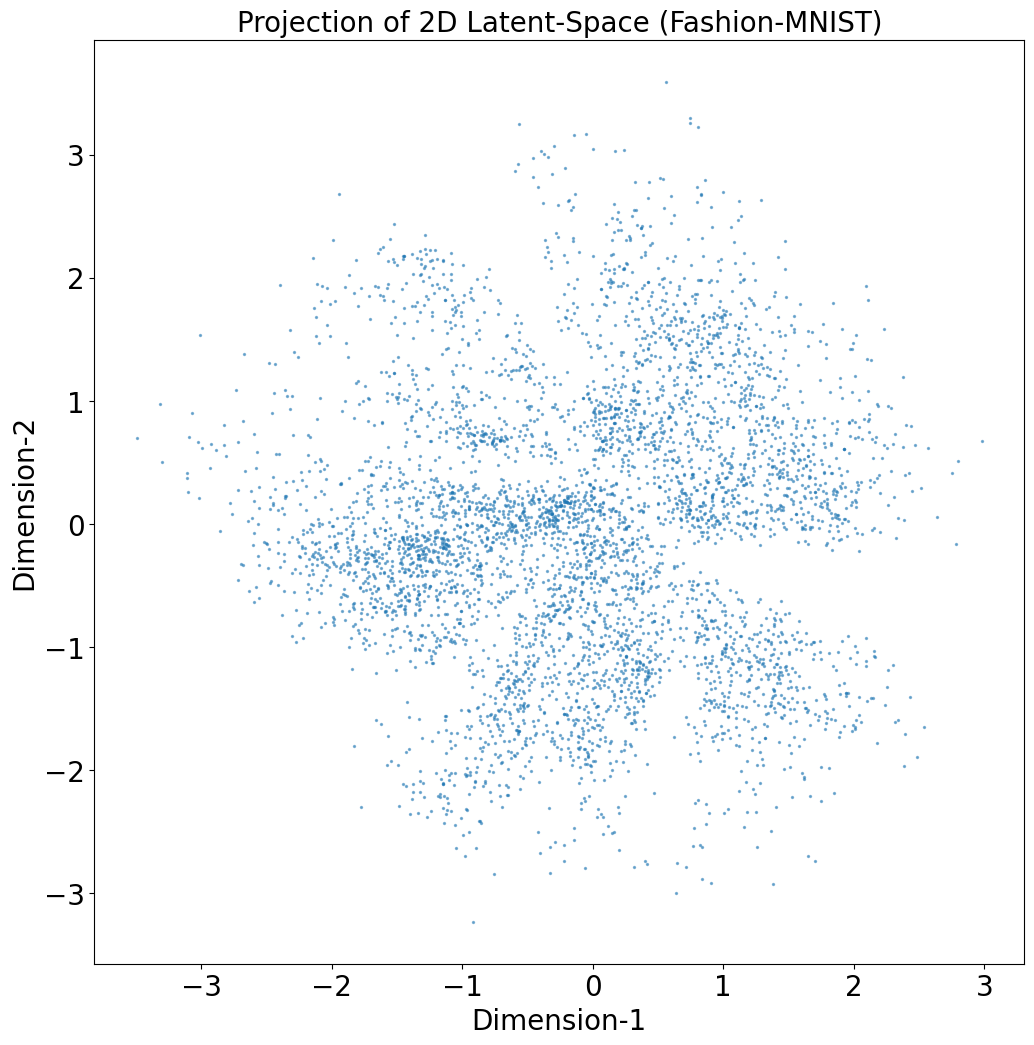

In [43]:
n_to_show = 5000  # Show 5000 different test images
figsize = 12

example_idx = np.random.choice(range(len(test_images)), n_to_show)
example_images = test_images[example_idx]

mean, var = encoder_model.predict(example_images)
embeddings = sampling_model([mean, var])


plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0] , embeddings[:, 1], alpha=0.5, s=2)  # embeddings.shape: TensorShape([5000, 2])
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Projection of 2D Latent-Space (Fashion-MNIST)", size=20)
plt.show()

In [44]:
# Create dictionary of target classes
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot',
}

### Reconstructing Fashion Images with Latent-Vector Sampled from Normal Distribution

1/1 [==============================] - 0s 196ms/step


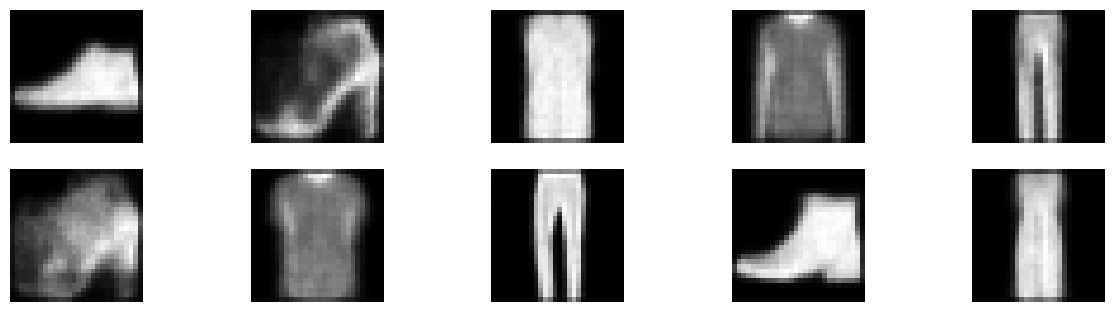

In [45]:
figsize = 15

x = np.random.normal(size = (10,2))
#x = np.random.uniform(size = (10,200))
reconstruct = decoder_model.predict(x)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.imshow(reconstruct[i, :,:,0]*255, cmap = 'gray')

### Reconstructing Test Images

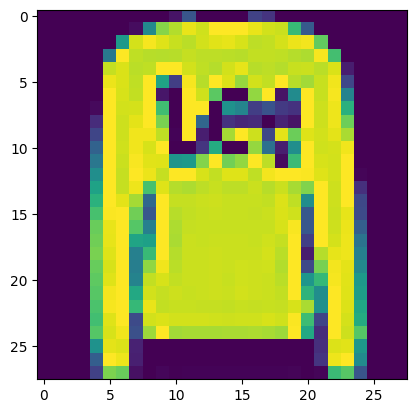

In [ ]:
plt.imshow(x_test[1])

1/1 [==============================] - 0s 170ms/step


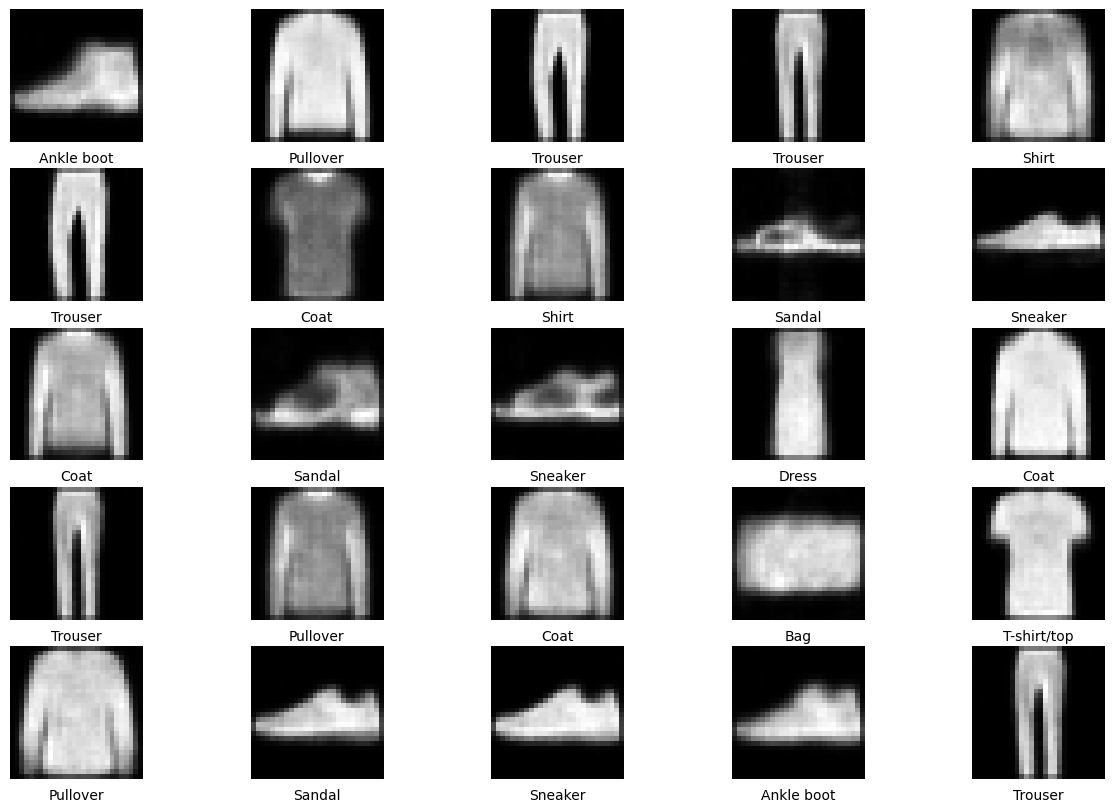

In [46]:
figsize = 15

# Run model in inference mode
mean, var = encoder_model.predict(test_images[:25])
latent = sampling_model([mean,var])
reconst = decoder_model.predict(latent)

fig = plt.figure(figsize=(figsize, 10))

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.text(0.5, -0.15, str(label_dict[y_test[i]]), fontsize=10, ha='center', transform=ax.transAxes)

    ax.imshow(reconst[i, :,:,0]*255, cmap = 'gray')

### Reconstructing Fashion Images with Latent-Vector Sampled Uniformly

1/1 [==============================] - 0s 18ms/step


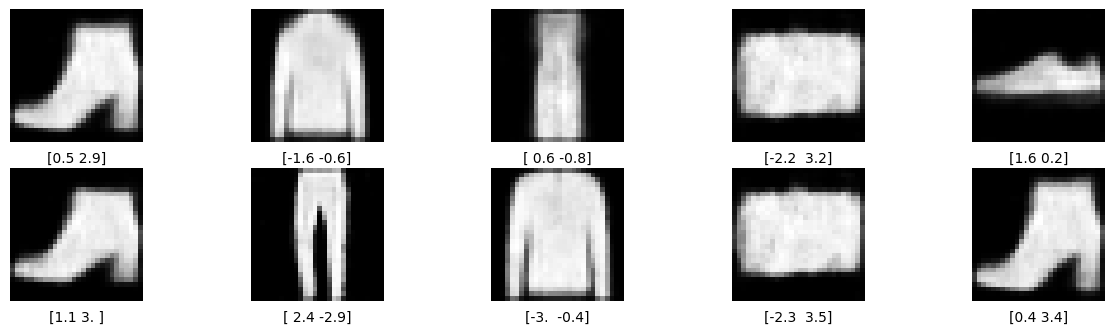

In [47]:
figsize = 15

min_x = min(embeddings[:, 0])
max_x = max(embeddings[:, 0])
min_y = min(embeddings[:, 1])
max_y = max(embeddings[:, 1])

x = np.random.uniform(min_x, max_x, size = (10,1))
y = np.random.uniform(min_y, max_y, size = (10,1))
z_grid = np.concatenate((x,y), axis=1)
reconst = decoder_model.predict(z_grid)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.text(0.5, -0.15, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)

    ax.imshow(reconst[i, :,:,0]*255, cmap = 'gray')

### Reference

[Convolutional Variational Autoencoder](https://www.tensorflow.org/tutorials/generative/cvae)

https://learnopencv.com/variational-autoencoder-in-tensorflow/

https://github.com/spmallick/learnopencv/blob/master/Variational-Autoencoder-TensorFlow/VAE_FashionMnist_TensorFlow.ipynb

https://mlarchive.com/deep-learning/variational-autoencoders-a-vanilla-implementation/

https://mbernste.github.io/posts/elbo/

https://abhinavkumarv29.medium.com/elbo-derivation-for-vae-variational-autoencoder-bb048fa1f55e